Importing Libraries

In [21]:
import cv2
import dlib
import numpy as np
from scipy import signal
#from eulerian_magnification import magnify_color

Initialize face detector and landmark predictor from Dlib

In [22]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

Helper function to extract facial landmarks

In [23]:
def get_landmarks(frame, face):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    landmarks = predictor(gray_frame, face)
    landmarks_points = []
    for i in range(0, 68):  # Using 68 face landmarks
        landmarks_points.append((landmarks.part(i).x, landmarks.part(i).y))
    return landmarks_points

 Function to apply motion magnification on a video

In [24]:
def apply_motion_magnification(input_video, amplification=50):
    magnified_video = []
    for frame in input_video:
        # Apply a Gaussian blur to the frame
        blurred_frame = cv2.GaussianBlur(frame, (5, 5), 0)
        # Calculate the difference between the original and blurred frames
        diff_frame = cv2.absdiff(frame, blurred_frame)
        # Amplify the difference
        amplified_frame = cv2.convertScaleAbs(diff_frame, alpha=amplification, beta=0)
        magnified_video.append(amplified_frame)
    return magnified_video

Divide face into ROI blocks (here we assume grid-based partitioning)

In [32]:
def get_face_rois(landmarks, frame):
    # Get bounding box for the face using key points
    (x_min, y_min) = np.min(landmarks, axis=0)
    (x_max, y_max) = np.max(landmarks, axis=0)

    # Define a grid (e.g., 5x5 ROIs)
    grid_size = 5
    rois = []
    h_step = (y_max - y_min) // grid_size
    w_step = (x_max - x_min) // grid_size

    for i in range(grid_size):
        for j in range(grid_size):
            x_start = x_min + j * w_step
            y_start = y_min + i * h_step
            x_end = x_start + w_step
            y_end = y_start + h_step
            rois.append([x_start, y_start, x_end, y_end])  # Return [x_start, y_start, x_end, y_end]
    return rois


Compute average color changes in each ROI over time

In [26]:
def compute_mmstr(rois, video_frames):
    roi_values = np.zeros((len(video_frames), len(rois)))

    # Loop through each frame in the video
    for t, frame in enumerate(video_frames):
        for i, roi in enumerate(rois):
            # Extract the mean color intensity over the region (simplified approach)
            x_start, y_start, width, height = roi
            x_end = x_start + width
            y_end = y_start + height
            roi_mean = np.mean(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)[y_start:y_end, x_start:x_end], axis=(0, 1))
            roi_values[t, i] = np.mean(roi_mean)  # Could use RGB separately or combined

    # Return the MMSTR map with the temporal variation of each ROI
    return roi_values

Load the video and extract frames

In [27]:
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    video_frames = []
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % 10 == 0:  # Process every 10th frame
            video_frames.append(frame)
        frame_count += 1
    cap.release()
    return video_frames

Main function to extract MMSTR from video

In [28]:
def extract_mmstr_from_video(video_path):
    # Load and magnify video
    video_frames = process_video(video_path)
    magnified_video = apply_motion_magnification(video_frames)

    # Detect face in the first frame
    face = detector(video_frames[0])[0]  # Assume one face for simplicity
    landmarks = get_landmarks(video_frames[0], face)

    # Get ROIs based on face landmarks
    rois = get_face_rois(landmarks, video_frames[0])

    # Compute the MMSTR
    mmstr_map = compute_mmstr(rois, magnified_video)

    return mmstr_map

Usage

In [35]:
mmstr_map = extract_mmstr_from_video("Dictators_-_Kim_Jong-Un_by_RepresentUs.webm.720p.vp9.webm")


Visualization of MMSTR (optional)

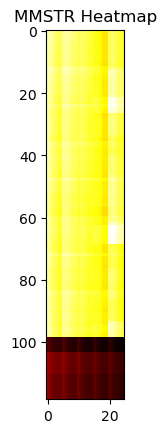

In [37]:
import matplotlib.pyplot as plt
plt.imshow(mmstr_map, cmap='hot', interpolation='nearest')
plt.title('MMSTR Heatmap')
plt.show()